In [2]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("../input"))


['plates']


In [3]:
data_root = '../input/plates/plates/plates'
print(os.listdir(data_root))

['test', 'train']


Divide our data to validation data and train data

In [4]:
import shutil
from tqdm import tqdm

train_dir = 'train'
# val_dir = 'val' // It was decided not to use validation in order to increase private score on competition
class_names = ['cleaned', 'dirty']
for class_name in class_names:
    os.makedirs(os.path.join('train', class_name), exist_ok=True)
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
#         if i % 6 != 0:
        dest_dir = os.path.join(train_dir, class_name)
#         else:
#             dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir,file_name))
        

100%|██████████| 20/20 [00:00<00:00, 306.85it/s]


In [5]:
!ls train/cleaned

0000.jpg  0003.jpg  0006.jpg  0009.jpg	0012.jpg  0015.jpg  0018.jpg
0001.jpg  0004.jpg  0007.jpg  0010.jpg	0013.jpg  0016.jpg  0019.jpg
0002.jpg  0005.jpg  0008.jpg  0011.jpg	0014.jpg  0017.jpg


In [6]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time 
import copy
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.determenistic = True

from torchvision import transforms, models

train_transforms1 = transforms.Compose([
    transforms.CenterCrop((256)),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# train_transforms2 = transforms.Compose([
#     torchvision.transforms.RandomRotation(degrees = (-10,10), resample=False, expand=True, center=None),
#     transforms.CenterCrop((256)),
#     transforms.Resize((224,224)),
#     transforms.RandomVerticalFlip(1.0),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

val_transforms = transforms.Compose([
    transforms.CenterCrop((256)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset1 = torchvision.datasets.ImageFolder(train_dir, train_transforms1)
# train_dataset2 = torchvision.datasets.ImageFolder(train_dir, train_transforms2)

# val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset1, batch_size=batch_size, shuffle = True, num_workers = batch_size)
# val_dataloader = torch.utils.data.DataLoader(
#     val_dataset, batch_size = batch_size, shuffle=False, num_workers=batch_size)


In [7]:
len(train_dataloader), len(train_dataset1)

(5, 40)

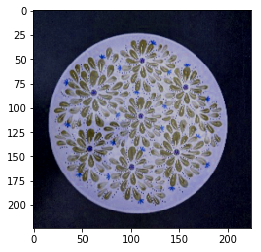

tensor(0)


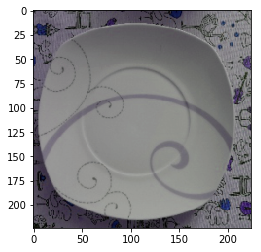

tensor(0)


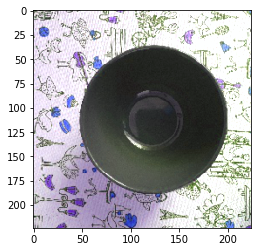

tensor(0)


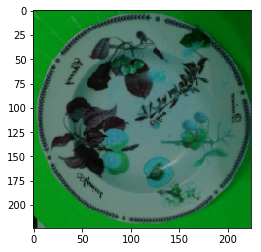

tensor(1)


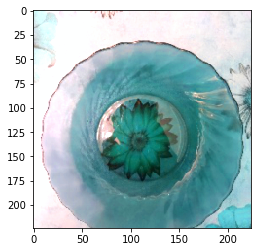

tensor(0)


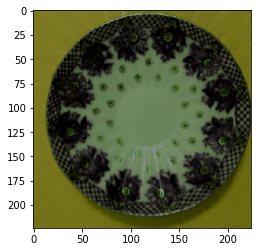

tensor(0)


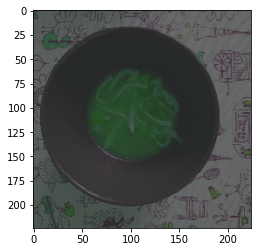

tensor(1)


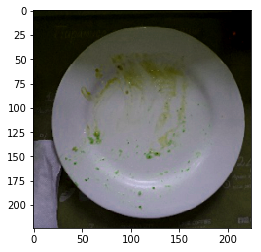

tensor(1)


In [8]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
for i in range(8):
    plt.imshow(X_batch[i].permute(1, 2, 0).numpy() * std + mean);
    plt.pause(0.001)
    print(y_batch[i])


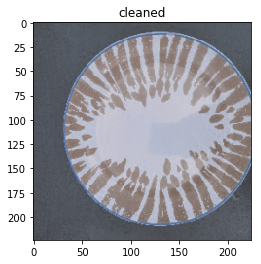

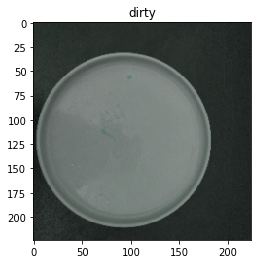

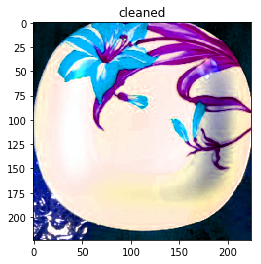

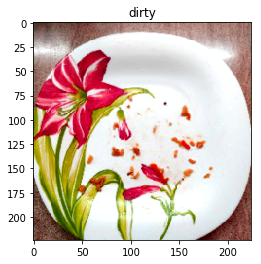

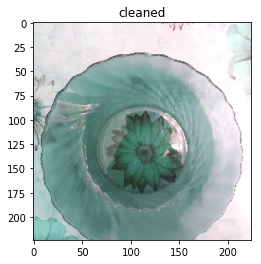

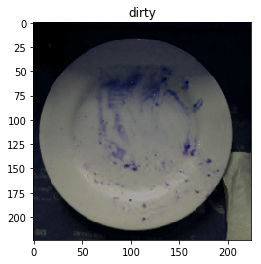

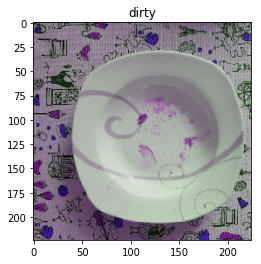

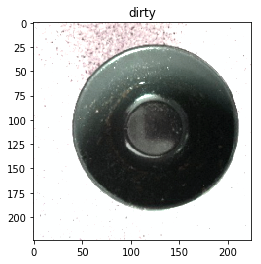

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [10]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
#     val_accuracy_history = []
#     val_loss_history = []
    train_loss_history = []
    train_accuracy_history = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        dataloader = train_dataloader
        model.train()  # Set model to training mode
        running_loss = 0.
        running_acc = 0.

            # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

                # forward and backward
            preds = model(inputs)
            loss_value = loss(preds, labels)
            preds_class = preds.argmax(dim=1)
            loss_value.backward()
            optimizer.step()

                # statistics
            running_loss += loss_value.item()
            running_acc += (preds_class == labels.data).float().mean()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        train_accuracy_history.append(epoch_acc.data.cpu())
        train_loss_history.append(epoch_loss)       
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc), flush=True)
        scheduler.step()
    plt.figure(1)
    plt.title('train_accuracy')
    plt.plot(train_accuracy_history)
    
    plt.figure(2)
    plt.title('train loss')
    plt.plot(train_loss_history, 'r')

    return model

In [12]:
model = models.resnet18(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features, 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4, amsgrad=True, weight_decay = 1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s] 


Epoch 0/59:
train Loss: 0.8228 Acc: 0.5750
Epoch 1/59:
train Loss: 0.4241 Acc: 0.8500
Epoch 2/59:
train Loss: 0.3056 Acc: 0.9000
Epoch 3/59:
train Loss: 0.1872 Acc: 0.9250
Epoch 4/59:
train Loss: 0.1358 Acc: 0.9500
Epoch 5/59:
train Loss: 0.0910 Acc: 0.9750
Epoch 6/59:
train Loss: 0.2307 Acc: 0.9000
Epoch 7/59:
train Loss: 0.0681 Acc: 1.0000
Epoch 8/59:
train Loss: 0.0842 Acc: 0.9750
Epoch 9/59:
train Loss: 0.0941 Acc: 0.9500
Epoch 10/59:
train Loss: 0.0408 Acc: 1.0000
Epoch 11/59:
train Loss: 0.0763 Acc: 0.9750
Epoch 12/59:
train Loss: 0.0634 Acc: 0.9750
Epoch 13/59:
train Loss: 0.1246 Acc: 0.9500
Epoch 14/59:
train Loss: 0.0650 Acc: 1.0000
Epoch 15/59:
train Loss: 0.0354 Acc: 1.0000
Epoch 16/59:
train Loss: 0.0354 Acc: 1.0000
Epoch 17/59:
train Loss: 0.0307 Acc: 1.0000
Epoch 18/59:
train Loss: 0.1042 Acc: 0.9750
Epoch 19/59:
train Loss: 0.0425 Acc: 1.0000
Epoch 20/59:
train Loss: 0.0842 Acc: 0.9500
Epoch 21/59:
train Loss: 0.0475 Acc: 1.0000
Epoch 22/59:
train Loss: 0.1151 Acc: 0.975

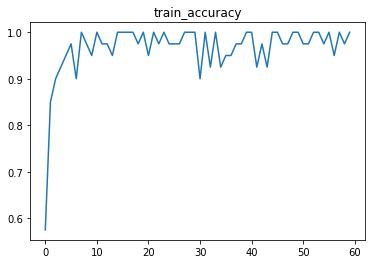

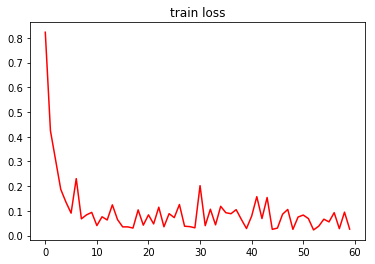

In [13]:
train_model(model, loss, optimizer, scheduler, num_epochs=60);

In [14]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [15]:
!ls 

__notebook__.ipynb  __output__.json  test  train


In [16]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [17]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 23.84it/s]


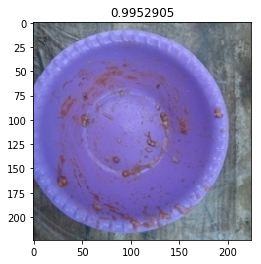

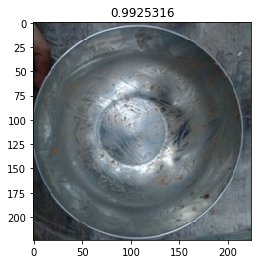

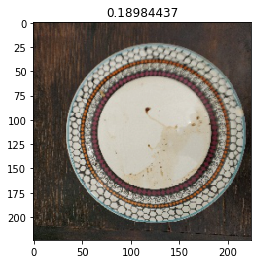

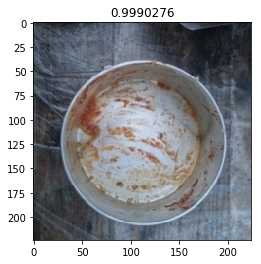

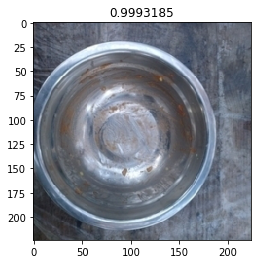

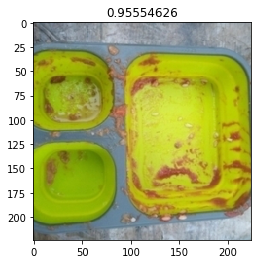

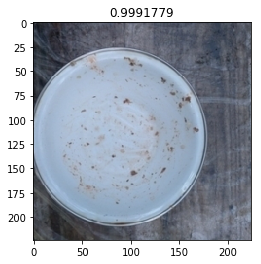

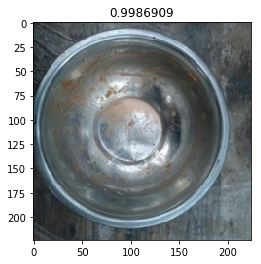

In [18]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [20]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [21]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [23]:
submission_df.to_csv('submission10.csv')

In [24]:
!rm -rf train val test